# Predicting

## 7) Realizando predicciones con el mejor modelo

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import time
import random
from itertools import product

In [9]:
class LeNet5(nn.Module):

    def __init__(self, image_size, n_canales_rgb, n_clases, cantidad_filtros_conv, tamaño_filtro_conv, 
                 tamaño_kernel_pooling, stride, padding):
        super().__init__()
        # cantidad de canales y clases, a definir por el diseñador
        self.n_canales_rgb = n_canales_rgb
        self.n_clases = n_clases
        self.tamaño_kernel_pooling = tamaño_kernel_pooling
        # Le net tiene dos capas convolucionales
        self.conv1 = nn.Conv2d(self.n_canales_rgb, cantidad_filtros_conv, kernel_size=tamaño_filtro_conv, stride=stride, padding=padding)
        
        outputconv1 = math.floor(((image_size - tamaño_filtro_conv + 2 * padding)/stride) + 1)
        # outputconv1 = math.floor(((128 - tamaño_filtro_conv)/stride))
        # falta un +1 al final ?? tener en cuenta el padding
        # asi seria? outputconv1 = math.floor(((128 - tamaño_filtro_conv + 2* padding)/stride) + 1)
        
        print("imagenes de salida post convolucion1:", outputconv1, "x", outputconv1)
        outputconv1 = math.floor(((outputconv1 - tamaño_kernel_pooling)/ stride ) + 1)
        print("imagenes de salida post pooling1:", outputconv1, "x", outputconv1)
        
        self.conv2 = nn.Conv2d(cantidad_filtros_conv, cantidad_filtros_conv*4, kernel_size=tamaño_filtro_conv, stride=stride, padding=padding)
        
        outputconv2 = math.floor((((outputconv1 - tamaño_filtro_conv)+ 2 * padding)/stride) + 1)
        print("imagenes de salida post convolucion2:", outputconv2, "x", outputconv2)
        outputconv2 = math.floor(((outputconv2 - tamaño_kernel_pooling)/ stride ) + 1)
        print("imagenes de salida post pooling2:", outputconv2, "x", outputconv2)

        # size del vector de parametros luego de las capas convolucionales
        cantidad_parametros = math.floor(cantidad_filtros_conv *4 * outputconv2 * outputconv2)
        print("cantidad de parametros en unrolling:",cantidad_parametros)
        # y tres capas de MLPs
        
        # primer MLP
        inputfc1 = math.floor(cantidad_parametros)
        print("parametros de entrada del primer perceptron:", inputfc1)
        outputfc1 = math.floor((1/2)*inputfc1)
        print("parametros de salida del primer perceptron:", outputfc1)
        
        self.fc1 = torch.nn.Linear(inputfc1, outputfc1)
        # segundo MLP
        inputfc2 = outputfc1
        print("parametros de entrada del segundo perceptron:", inputfc2)
        outputfc2 = math.floor(inputfc2*(1/2))
        print("parametros de salida del segundo perceptron:", outputfc2)
        self.fc2 = torch.nn.Linear(inputfc2, outputfc2)
        # tercer MLP. salida con cantidad de clases
        inputfc3 = outputfc2
        print("parametros de entrada del tercer perceptron:", inputfc3)
        self.fc3 = torch.nn.Linear(inputfc3, self.n_clases)

    def forward(self, x):
        # capa convolucional
        x = self.conv1(x)
        # al resultado de la convolucion, le aplica una ReLu
        x = F.relu(x)
        # y luego un pooling
        x = F.max_pool2d(x, (self.tamaño_kernel_pooling, self.tamaño_kernel_pooling))
        
        # Segunda capa convolucional
        x = self.conv2(x)
        # aplica relu
        x = F.relu(x)
        # pooling 
        x = F.max_pool2d(x, (self.tamaño_kernel_pooling, self.tamaño_kernel_pooling))
        
        # flatten de las imagenes para pasarlo a MLPs
        x = torch.flatten(x, 1)
        # MLPs con relus
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [11]:
# Load
model_predict = torch.load("best_model_cpu.pt")
model_predict.eval()

LeNet5(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1568, bias=True)
  (fc2): Linear(in_features=1568, out_features=784, bias=True)
  (fc3): Linear(in_features=784, out_features=5, bias=True)
)

In [12]:
device = "mps"

In [13]:
model_predict.to(device)

LeNet5(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1568, bias=True)
  (fc2): Linear(in_features=1568, out_features=784, bias=True)
  (fc3): Linear(in_features=784, out_features=5, bias=True)
)

In [19]:
from PIL import Image

class_names = ['Boton chico', 'Boton grande', 'Duracell', 'Energizer', 'Otras']

def get_prediction(tensor, device):
    tensor = tensor.to(device)
    output = model_predict.forward(tensor)
     
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    return conf.item(), class_names[classes.item()]

def predict_path_image(path):
    '''para jugar con predicciones del dataset que ya tenemos armado'''
    # muestro la imagen
    image_path= path
    image = plt.imread(image_path)
    plt.imshow(image)

    # imagen a tensor y predecir, imprimir prediccion
    img = Image.open(image_path)

    convert_tensor = transforms.ToTensor()
    tensor = convert_tensor(img)
    tensor = tensor.unsqueeze(0)
    tensor = tensor.to(device)

    conf, y_pre = get_prediction(tensor= tensor, device = device)
    print(y_pre, ' at confidence score: {0:.2f}\n'.format(conf))

import sys, os
   
def predict_new_image(path):
    '''para imagenes en distintos tamaños a las de nuetro dataset, como las que se podrian 
    sacar una camara normal en la vida real, tenemos que resizear las imagenes a 128x128'''
    
    final_size = 128
    
    im = Image.open(path)
    f, e = os.path.splitext(path)
    size = im.size
    ratio = float(final_size) / max(size)
    new_image_size = tuple([int(x*ratio) for x in size])
    im = im.resize(new_image_size, Image.ANTIALIAS)
    new_im = Image.new("RGB", (final_size, final_size))
    
    new_im.paste(im, ((final_size-new_image_size[0])//2, (final_size-new_image_size[1])//2))
    
    # muestro la imagen
    plt.imshow(new_im)
    
    
    # imagen a tensor y predecir, imprimir prediccion
    img = new_im

    convert_tensor = transforms.ToTensor()
    tensor = convert_tensor(img)
    tensor = tensor.unsqueeze(0)
    tensor = tensor.to(device)

    conf, y_pre = get_prediction(tensor= tensor, device = device)
    print(y_pre, ' at confidence score: {0:.2f}\n'.format(conf))
    

Energizer  at confidence score: 1.00



/var/folders/36/xhls1xbs1676nkndj0s_rtnr0000gn/T/ipykernel_10090/2661477481.py:44: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = im.resize(new_image_size, Image.ANTIALIAS)


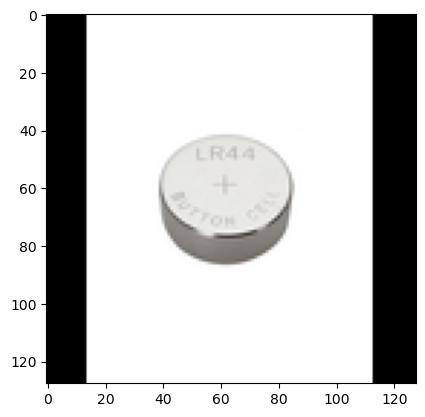

In [31]:
predict_new_image("botonsito.jpeg")

Boton chico  at confidence score: 1.00



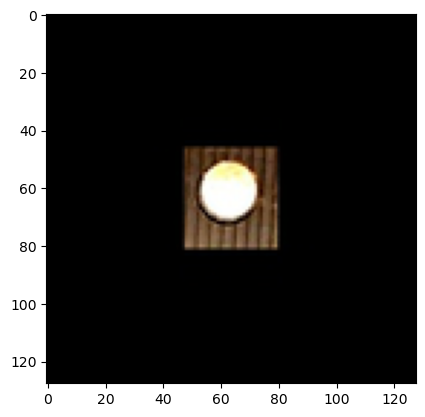

In [16]:
predict_path_image("FinalDataset/test/Boton chico/075.jpg_contrast.jpg")